In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import string
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from retell_utils.metrics import get_cosine_sim, jaccard_text, plot_bar_jac_cos_metric
from tqdm.notebook import tqdm
from pathlib import Path
from retell_utils.corpora_sugar import CorpusSugar
from tg.grammar_ru.corpus import CorpusReader

In [2]:
from tg.common._common import DataBundle

In [3]:
retell_corpus = CorpusReader(Path("./featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("./featurized_corpuses/books.featurized.zip"))
martin_mapping = retell_corpus.read_mapping_data()

In [4]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')

In [5]:
model_path = Path("./navec_hudlit_v1_12B_500K_300d_100q.tar")
navec = Navec.load(model_path)
embeder = NavecEmbedding(navec)

/home/mixailkys/anaconda3/envs/grammar_ru/lib/python3.8/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402316912/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.from_numpy(navec.pq.indexes),


In [6]:
db = DataBundle.load('./Martin-bundle.zip')
martin_spec_word_vocab = db.words.set_index('word').nf_n.to_dict()

In [7]:
fine_tuned_vec = pd.read_csv(Path("./Martin-nonce-freq-joint.csv"), sep='\t').iloc[:, 1:]
better_fine_tuned_vec = pd.read_csv(Path("./Martin-better.csv"), sep='\t').iloc[:, 1:]

In [8]:
fine_tuned_vec

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,0.078562,-0.149655,-0.150364,0.249070,-0.212301,-0.057017,-0.063265,0.071950,-0.024585,-0.164026,...,0.197237,0.084040,-0.128762,-0.251915,-0.075777,0.037815,-0.072577,0.254591,-0.156577,10.047770
1,0.239270,-0.111247,0.019034,0.103700,-0.234546,-0.142890,-0.005711,0.046616,-0.130710,0.040332,...,-0.127117,0.043515,-0.079331,-0.275815,-0.153601,0.040854,0.021165,0.006768,-0.090977,7.619809
2,0.166898,-0.045892,0.204491,0.021266,-0.031156,0.133396,-0.123712,0.126124,-0.034461,-0.123917,...,-0.238819,0.129897,-0.063659,-0.277777,0.014659,0.002224,0.019845,0.047059,0.048151,6.699155
3,-0.282157,0.257812,0.154728,-0.002214,-0.396217,0.379055,0.322976,-0.140838,0.068028,-0.150257,...,-0.226491,-0.103059,0.032430,-0.012872,0.104019,-0.115509,0.104306,0.085083,0.034918,-0.746034
4,-0.134081,-0.150762,0.382866,0.014230,-0.079229,-0.072625,0.145221,0.107703,0.287233,0.069872,...,-0.196095,0.269739,0.090484,0.227618,-0.014680,-0.106048,-0.328925,-0.250228,0.267152,-7.142938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22719,-0.183731,-0.164664,-0.147866,-0.075879,-0.506226,-0.096745,0.465308,-0.108243,0.159901,0.073891,...,0.007066,-0.395104,-0.229404,-0.169331,-0.149122,-0.439416,0.229929,-0.193889,-0.183202,-2.231250
22720,-0.612528,0.140600,0.080018,0.209475,-0.083971,0.421585,0.083721,-0.119106,0.638967,0.007093,...,-0.293196,-0.106125,0.204108,-0.286618,0.313053,0.055532,0.199639,-0.058503,0.048637,-2.551485
22721,0.004930,-0.089103,0.128378,-0.018897,-0.222218,0.257464,-0.011307,0.392141,0.334541,0.025384,...,0.027572,0.084807,0.281078,-0.013508,0.431241,-0.075631,0.036951,0.056186,-0.014317,-3.662147
22722,-0.082320,-0.049989,0.128470,-0.028104,-0.268497,0.412939,-0.050845,0.151159,0.375527,-0.080062,...,-0.151502,0.168638,0.237744,0.070377,0.431631,-0.022061,-0.084824,0.161286,-0.046993,-3.697859


In [34]:
def get_sentences(chapter):
    chptr = text_corpus.get_bundles([chapter]).single()
    chapter_id = chptr.src
    sentences_id = np.array(chapter_id['sentence_id'].unique())
    sentences = [chapter_id['word'].values[chapter_id['sentence_id'] == sentence_id]
                 for sentence_id in sentences_id]
    return sentences


def get_classic_embeding(token,martin_vec = fine_tuned_vec):
    if token in martin_spec_word_vocab:
        return torch.tensor(martin_vec.iloc[martin_spec_word_vocab[token]][:300])
    else:
        return embeder(torch.tensor(navec.vocab['<unk>']))


def get_split_tokens_embeding_part(token: str,martin_vec = fine_tuned_vec):
    get_martin_emd = lambda tok: torch.tensor(
        martin_vec.iloc[martin_spec_word_vocab[tok]][:300])
    token_splited = token.split('-')
    if len(token_splited) == 2 and len(token_splited[0]) > 2:
        if len(token_splited[1]) > 2:
            if token_splited[0] in martin_spec_word_vocab and token_splited[1] in martin_spec_word_vocab:
                return get_martin_emd(token_splited[0]) + \
                    get_martin_emd(token_splited[1])
        elif token_splited[1] in ["ка", "то"]:
            return get_martin_emd(token_splited[0])

    if token in martin_spec_word_vocab:
        return get_martin_emd(token)
    else:
        return embeder(torch.tensor(navec.vocab['<unk>']))


def get_split_tokens_embeding_full(token: str,martin_vec = fine_tuned_vec):
    get_martin_emd = lambda tok: torch.tensor(martin_vec.iloc[martin_spec_word_vocab[tok]])
    token_splited = token.split('-')
    if len(token_splited) == 2 and len(token_splited[0]) > 2:
        if len(token_splited[1]) > 2:
            if token_splited[0] in martin_spec_word_vocab and token_splited[1] in martin_spec_word_vocab:
                return get_martin_emd(token_splited[0]) + \
                    get_martin_emd(token_splited[1])
        elif token_splited[1] in ["ка", "то"]:
            return get_martin_emd(token_splited[0])

    if token in martin_spec_word_vocab:
        return get_martin_emd(token)
    else:
        return embeder(torch.tensor(navec.vocab['<unk>']))

In [10]:
ban_words = set(string.punctuation + "«—»…")
ban_words.update(["!!", "!?", "?!", "??", "?.."])

In [21]:
def get_extract_retell(embeding_func, retell_detail=5,martin_vec = fine_tuned_vec):
    for book in books[:1]:
        extract_retell = []
        for chapter in tqdm(book.index):
            sentences = get_sentences(chapter)
            vec_sum_sentences = []
            for sentence in sentences:
                tokens = [word.lower() for word in sentence if word not in ban_words]
                sentence_vector_sum = sum([embeding_func(token,martin_vec) for token in tokens])
                vec_sum_sentences.append(sentence_vector_sum / len(tokens) if len(tokens) > 0 else torch.zeros(300))
            importances = []
            cos = torch.nn.CosineSimilarity(dim=0)
            for i in range(len(vec_sum_sentences)):
                importance = 0
                for j in range(i, len(vec_sum_sentences)):
                    importance += cos(vec_sum_sentences[i], vec_sum_sentences[j])
                importances.append(importance)
            sorted_index_array = np.argsort(importances)[::-1]
            top_sentences = [" ".join(sentences[id]) for id in sorted_index_array[:retell_detail]]
            extract_retell.append("\n".join(top_sentences))
        return extract_retell  # TODO Если будет несколько книг, нужно сдвинуть return до первого for-а

In [22]:
def better_get_extract_retell__(embeding_func, retell_detail=5,martin_vec = fine_tuned_vec):
    for book in books[:1]:
        extract_retell = []
        for chapter in tqdm(book.index):
            sentences = get_sentences(chapter)
            vec_sum_sentences_f = []
            vec_sum_sentences_s = []
            for sentence in sentences:
                tokens = [word.lower() for word in sentence if word not in ban_words]
                embeded = [embeding_func(token,martin_vec) for token in tokens]
                sentence_vector_sum_f = sum([vec[:300] if len(vec) > 300 else vec for vec in embeded])
                sentence_vector_sum_s = sum([vec[301:601] if len(vec) > 300 else vec for vec in embeded])
                vec_sum_sentences_f.append(sentence_vector_sum_f / len(tokens) if len(tokens) > 0 else torch.zeros(300))
                vec_sum_sentences_s.append(sentence_vector_sum_s / len(tokens) if len(tokens) > 0 else torch.zeros(300))
            importances = []
            cos = torch.nn.CosineSimilarity(dim=0)
            for i in range(len(vec_sum_sentences_f)):
                importance = 0
                for j in range(len(vec_sum_sentences_f)):
                    if i != j:
                        importance += cos(vec_sum_sentences_f[i], vec_sum_sentences_s[j])
                importances.append(importance)
            sorted_index_array = np.argsort(importances)[::-1]
            top_sentences = [" ".join(sentences[id]) for id in sorted_index_array[:retell_detail]]
            extract_retell.append("\n".join(top_sentences))
        return extract_retell  # TODO Если будет несколько книг, нужно сдвинуть return до первого for-а

In [13]:
retell_detail = 5

In [39]:
embed_dict_names = ['base','better']
importance_calc_names = ['simular_vec','base_contex_vec']
embeder_names = ['2dict','split_part','split_full']

In [35]:
extract_result = {}
i = 0
for embed_dict, embed_dict_name in zip([fine_tuned_vec,better_fine_tuned_vec],['base','better']):
    extract_result[embed_dict_name] = {}
    for importance_calc, importance_calc_name in zip([get_extract_retell,better_get_extract_retell__],['simular_vec','base_contex_vec']):
        extract_result[embed_dict_name][importance_calc_name] = {}
        for embed,embed_name in zip([get_classic_embeding,get_split_tokens_embeding_part,get_split_tokens_embeding_full],['2dict','split_part','split_full']):
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            extract_retell = importance_calc(embed,retell_detail,embed_dict)
            extract_result[embed_dict_name][importance_calc_name][embed_name] = extract_retell
            i+=1
            print(f"Пересказов выполнено: {i}")

  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 1


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 2


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 3


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 4


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 5


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 6


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 7


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 8


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 9


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 10


In [82]:
import os
separator ="\n<separator>\n"
dir_name = "retell_fine_tuned"
if not os.path.isdir(dir_name):
    os.mkdir("retell_fine_tuned")
os.chdir("retell_fine_tuned")
for embed_dict_name in embed_dict_names:
    for importance_calc_name in importance_calc_names:
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            file_name = embed_dict_name+"_"+importance_calc_name+"_"+embed_name
            retell_text = extract_result[embed_dict_name][importance_calc_name][embed_name]
            with open(f'{file_name}.txt', 'w') as f:
                for line in retell_text:
                    f.write(f"{line}{separator}")
os.chdir("../")

In [40]:
true_retell = []
for book in retell_books[:1]:
    for chapter in book.index:
        chptr = retell_corpus.get_bundles([chapter]).single().src
        sentences_id = np.array(chptr['sentence_id'].unique())
        sentences = [chptr['word'][chptr['sentence_id'] == sentence_id] for sentence_id in sentences_id]
        true_retell.append("\n".join(" ".join(sentence.values) for sentence in sentences[:retell_detail]))

In [43]:
list_jaccard_sim, list_cos_sim = {}, {}
names = []
for embed_dict_name in embed_dict_names:
    list_jaccard_sim[embed_dict_name] = {}
    list_cos_sim[embed_dict_name] = {}
    for importance_calc_name in importance_calc_names:
        list_jaccard_sim[embed_dict_name][importance_calc_name] = {}
        list_cos_sim[embed_dict_name][importance_calc_name] = {}
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            retell = extract_result[embed_dict_name][importance_calc_name][embed_name]
            jaccard_sim = np.array([jaccard_text(retell[i], true_retell[i]) for i in range(len(true_retell))])
            cos_sim = np.array([get_cosine_sim(retell[i], true_retell[i]) for i in range(len(true_retell))])
            list_jaccard_sim[embed_dict_name][importance_calc_name][embed_name] = jaccard_sim
            list_cos_sim[embed_dict_name][importance_calc_name][embed_name] = cos_sim

In [60]:
def bar_jac_cos_metric(embed_dict_name, metric,metric_name):
    v, h = 3, 2
    fig, axis = plt.subplots(v, h,figsize=(8,8))
    fig.suptitle(f'{metric_name} - {embed_dict_name}')
    for i, embed_name  in enumerate(embeder_names):
        for j, importance_calc_name in enumerate(importance_calc_names):
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            metr_value = metric[embed_dict_name][importance_calc_name][embed_name]
            axis[i,j].bar(range(len(metr_value)), metr_value)
            axis[i,j].set_title(importance_calc_name + " " + embed_name)
    plt.subplots_adjust(left=0, right=1, wspace=0.2, hspace=0.8)


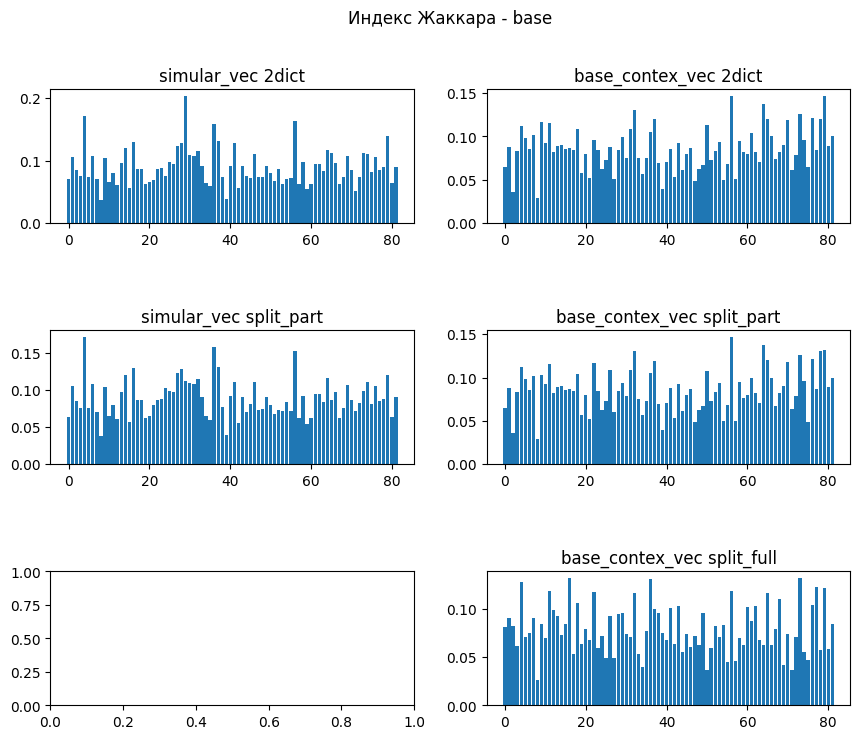

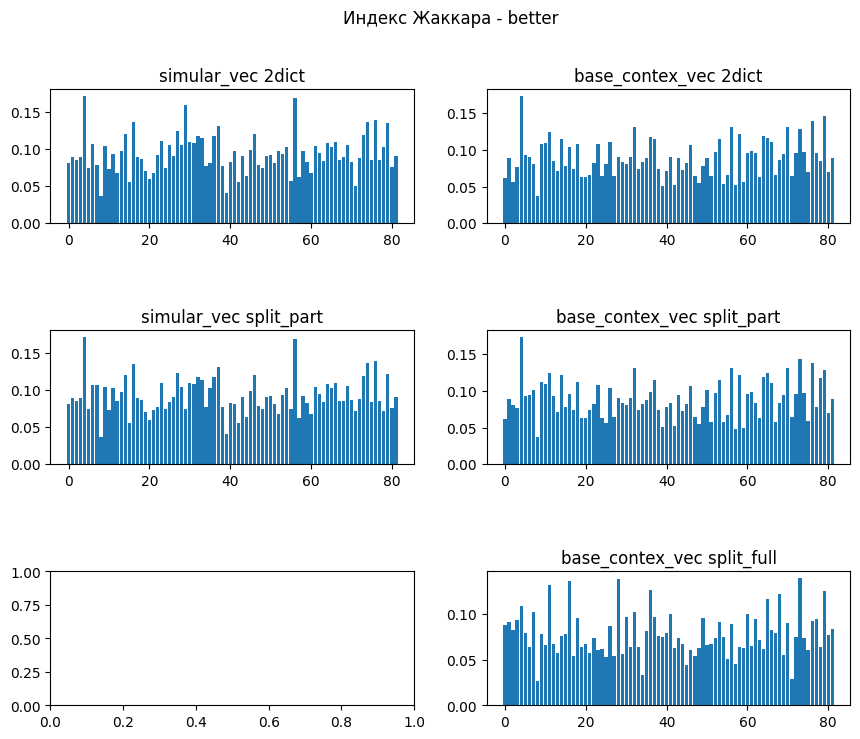

In [63]:
bar_jac_cos_metric('base', list_jaccard_sim,"Индекс Жаккара")
bar_jac_cos_metric('better', list_jaccard_sim,"Индекс Жаккара")

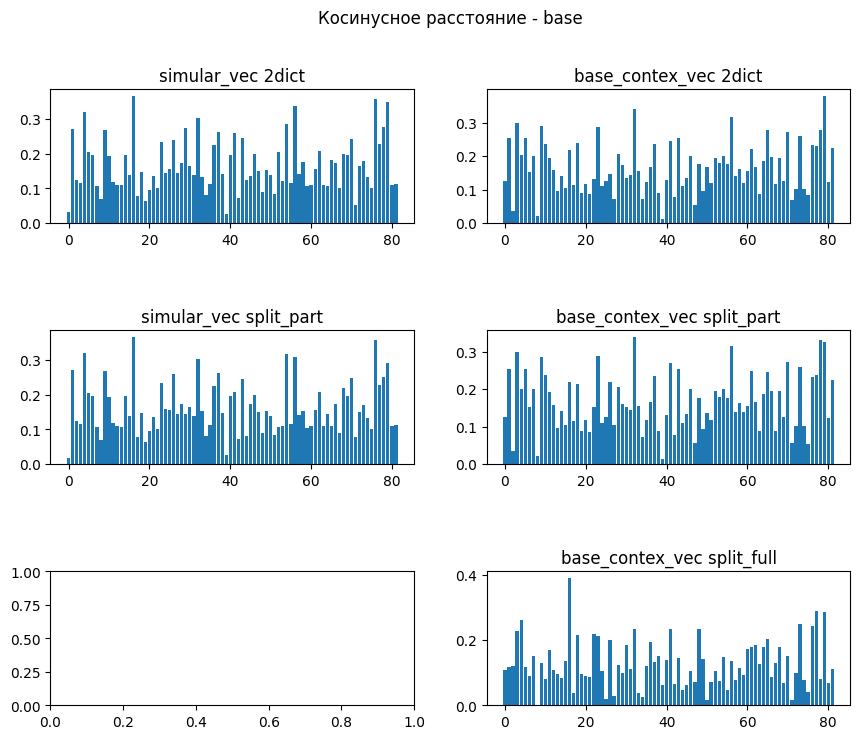

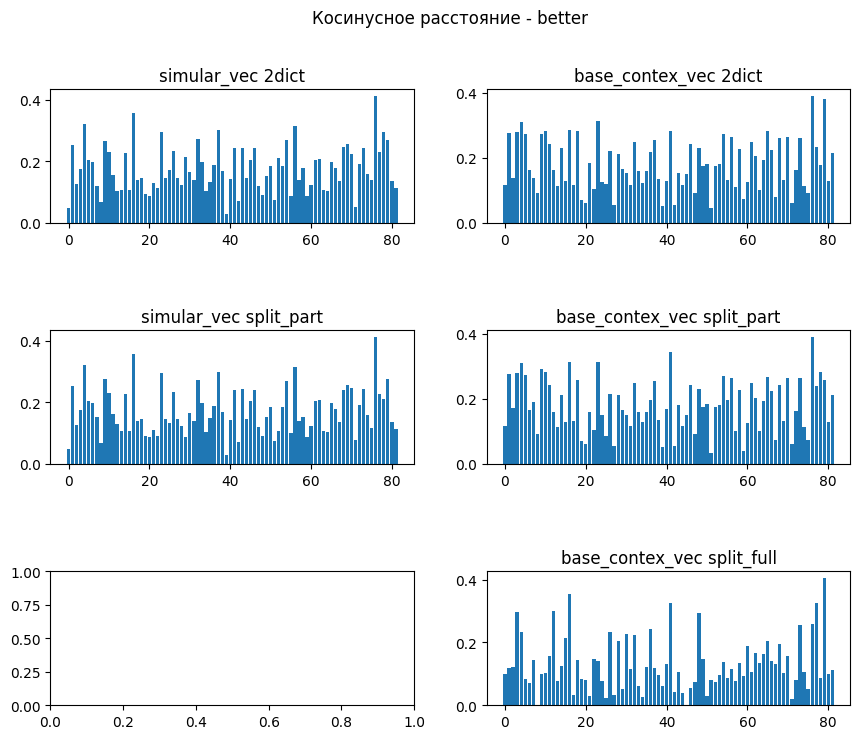

In [64]:
bar_jac_cos_metric('base', list_cos_sim,"Косинусное расстояние")
bar_jac_cos_metric('better', list_cos_sim,"Косинусное расстояние")

In [119]:
jacc_med, cos_med, name_comb = [], [], []
jacc_maxis, cos_maxis = [], []
best_jacc_text, best_cos_text,best_index_jacc,best_index_cos = '','',-1,-1
j_maxis, c_maxis = -1, -1
for embed_dict_name in embed_dict_names:
    for importance_calc_name in importance_calc_names:
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                    continue
            name_comb.append(embed_dict_name + " " + importance_calc_name + " " + embed_name)
            jac_val = list_jaccard_sim[embed_dict_name][importance_calc_name][embed_name]
            cos_val = list_cos_sim[embed_dict_name][importance_calc_name][embed_name]
            jacc_mean, jac_max,ii = np.median(jac_val), np.max(jac_val),np.argmax(jac_val)
            cos_mean, cos_max,jj =  np.median(cos_val), np.max(cos_val),np.argmax(cos_val)
            if jac_max >= j_maxis:
                j_maxis = jac_max
                best_index_jacc = ii
                best_jacc_text = extract_result[embed_dict_name][importance_calc_name][embed_name][best_index_jacc]

            if cos_max >= c_maxis:
                c_maxis = cos_max
                best_index_cos = jj
                best_cos_text = extract_result[embed_dict_name][importance_calc_name][embed_name][best_index_cos]
            jacc_med.append(jacc_mean)
            jacc_maxis.append(jac_max)
            cos_med.append(cos_mean)
            cos_maxis.append(cos_max)

<BarContainer object of 10 artists>

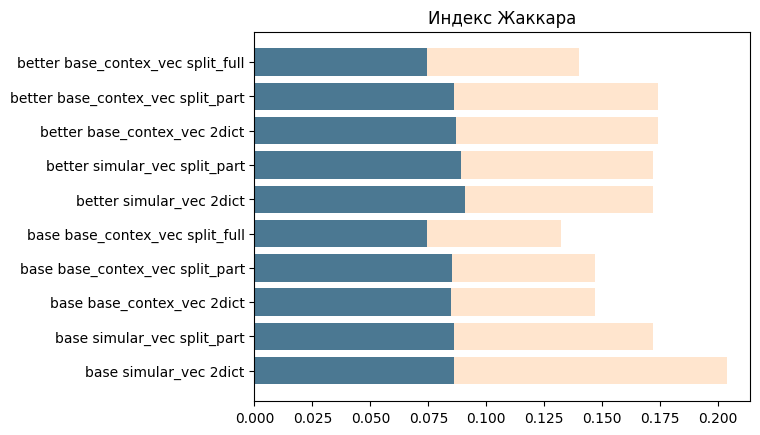

In [109]:
plt.title("Индекс Жаккара")
plt.barh(name_comb, jacc_med,label='mediana')
plt.barh(name_comb, jacc_maxis, label='max', alpha=0.2)

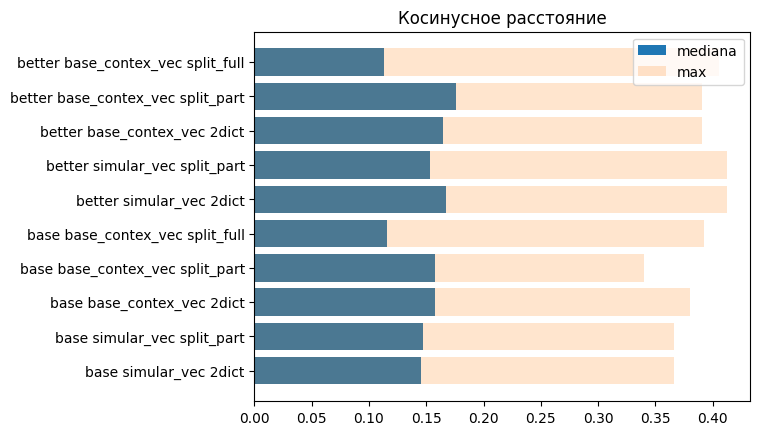

In [110]:
plt.title("Косинусное расстояние")
plt.barh(name_comb, cos_med,label='mediana')
plt.barh(name_comb, cos_maxis, label='max',alpha=0.2)
plt.legend()

In [121]:
print("Лучший пересказ по Индексу Жаккара")
display(best_jacc_text)
print()
true_retell[best_index_jacc]

Лучший пересказ по Индексу Жаккара


'— Как у вас с едой ? — спросил его Том .\nЯ бы сказал , что его растерзанный труп очень бы даже устроил — как и меня .\n— Люди Безумного Короля охотились за Робертом , стараясь схватить его до того , как он соединится с вашим отцом , — рассказывал он , когда они въезжали в ворота .\nПо виду города Арья рассудила , что здесь и в последнее время не обошлось без битв .\nНо Роберта он найти не успел , потому что лорд Эддард и ваш дед подошли к городу и взяли приступом его стены .'

'Арья , Джендри и разбойники из Братства Без Знамен добрались до Каменной Септы .\nХарвин рассказал Арье , что одно из главных сражений восстания Роберта Баратеона - Колокольная битва случилась в Каменной Септе .\nДесница лорд Коннингтон пришел в город с большим войском и стал обыскивать дом за домом .\nВ это время Эддард Старк и Хостер Талли подошли к городу и взяли приступом его стены .\nБорьба бушевала по всему городу .'

In [124]:
print("Лучший пересказ по косинусному расстоянию")
display(best_cos_text)
print()
true_retell[best_index_cos]

Лучший пересказ по косинусному расстоянию


'— Что нужно от меня его величеству ? — спросил Джон , когда они вошли в клеть .\n— Не « он » , — отметил Джон про себя — « мы » .\n— Он и должен быть тяжелым , чтобы остановить меч .\nНастоящая королева — она , а не та , которую Станнис оставил в Восточном Дозоре .\nЗначит , правда то , что все говорят .'

'Джон Сноу во дворе тренирует новобранцев Ночного Дозора .\nЕго тренировку прерывает Мелисандра , и сообщает , что король Станнис ждёт его на Стене .\nНаверху Джон пытается объяснить Станнису , что он не предатель , и король верит ему : Джон похож на своего отца Эддарда , а тот был человеком чести .\nВ то же время Джон говорит , что у одичалых тоже есть своё понятие чести , правда не у всех .\nСтаннис сообщает , что он приехал на Стену , потому что королевство нуждается в защите от действительно настоящего врага - Бога Ночи и Ужаса .'

In [186]:
def display_arg_max_min_text(retell_, true_text, sim_metric):
    argmax = sim_metric.argmax()
    argmin = sim_metric.argmin()
    display("Текст с наибольшим значением метрики")
    display(retell_[argmax])
    display(true_text[argmax])
    display("Текст с наименьшим значением метрики")
    display(retell_[argmin])
    display(true_text[argmin])

In [187]:
display("Коэфициент Жаккара")
display_arg_max_min_text(split_strategy_extract_retell, true_retell, jaccard_sim)

'Коэфициент Жаккара'

'Текст с наибольшим значением метрики'

'Но Роберта он найти не успел , потому что лорд Эддард и ваш дед подошли к городу и взяли приступом его стены .\n— Люди Безумного Короля охотились за Робертом , стараясь схватить его до того , как он соединится с вашим отцом , — рассказывал он , когда они въезжали в ворота .\nЭту битву потом назвали Колокольной , и Роберт всегда говорил , что ее выиграл ваш отец , а не он .\n— Как у вас с едой ? — спросил его Том .\nКаменная Септа была самым большим городом , который Арья видела после Королевской Гавани , и Харвин сказал ей , что здесь произошла битва , в которой одержал победу ее отец .'

'Арья , Джендри и разбойники из Братства Без Знамен добрались до Каменной Септы .\nХарвин рассказал Арье , что одно из главных сражений восстания Роберта Баратеона - Колокольная битва случилась в Каменной Септе .\nДесница лорд Коннингтон пришел в город с большим войском и стал обыскивать дом за домом .\nВ это время Эддард Старк и Хостер Талли подошли к городу и взяли приступом его стены .\nБорьба бушевала по всему городу .'

'Текст с наименьшим значением метрики'

'Если мы и погибнем , думал Джон , то никто по крайней мере не будет убит в своей постели .\nПосле его побега Стир потерял надежду взять Черный Замок врасплох , но все равно — зачем же предупреждать о своем приближении столь откровенно ?\nОна не гнется , но я могу на ней ковылять , и драться тоже смогу , если я тебе нужен .\nПоставим тебя на башню с длинным луком , но если ты сверзишься оттуда , не приходи ко мне жаловаться .\n— Я могу сражаться , — заявил Джон , когда его попытались остановить .'

'Братья Ночного Дозора и эвакуированные жители Кротового Городка готовятся к нападению на Чёрный замок одичалых .\nДонал Нойе расставил всех по своим местам .\nКаждый должен был защищать свой участок .\nДжон Сноу оказался на вершине Королевской Башни вместе с Диком Фоллардом и Атласом .\nОни должны были стрелять сверху по врагам .'

In [188]:
display("Косинусное расстояние")
display_arg_max_min_text(split_strategy_extract_retell, true_retell, cos_sim)

'Косинусное расстояние'

'Текст с наибольшим значением метрики'

'— Ее величество сказали , что вы теперь взрослая и должны одеваться , как взрослая девушка .\nОна уже много лет оказывает мне честь , заказывая у меня платья .\nНовое платье ей будет очень кстати , это правда .\nОна стала замечать , что и взрослые мужчины смотрят на ее грудь , и некоторые сорочки стали ей так тесны , что она едва могла в них дышать .\n— Грудь у вас обещает быть такой же красивой , как у королевы , — сказала портниха , измеряя ее объем .'

'Королева Серсея распорядилась сшить платье для Сансы .\nНовое платье будет ей весьма кстати - за год она выросла , к тому же свой гардероб она испортила дымом , пытаясь сжечь окровавленный тюфяк .\nСанса сближается с девицами Тирелл и много времени проводит в их компании .\nС Маргери она отправляется на соколиную охоту , где просит её не выходить замуж за Джоффри .\nНа что Маргери отвечает , что не боится Джоффри , потому что ее отец заставил взять в Королевскую гвардию Лораса еще до того , как согласился на этот брак .'

'Текст с наименьшим значением метрики'

'При этом он выронил факел , огонь охватил его одежду , он закричал и тем предупредил своих об опасности .\nОн сделал еще несколько шагов , но еще две стрелы ударили в него почти одновременно , пробив панцирь так , словно тот был шелковым , а не стальным .\nАрью возмущало , что ее держат в тылу , как малого ребенка , но Джендри тоже в бой не взяли .\nФехтование ей нравилось больше , но от стрел , как она убедилась , тоже бывает большая польза .\nКайл и Нотч выстрелили разом , и один караульный рухнул со стрелой в горле , а другой в животе .'

'Братство без Знамён атакует септу , захваченную Бравыми Ребятами .\nЗасевшие там скоморохи вынуждены выбегать наружу , после того , как Энгай и другие лучники поджигают здание .\nОставшихся в живых берут в плен .\nСреди них септон Утт , жестокость которого Арья помнила по Харренхоллу .\nРазбойников тут же предают суду и вешают на дереве .'

Можно тут вариации гистограм метрик нарисовать (С дефолтным расчётом важности, с Сашиным/ Со сплитом в эмбединге, без него/ С первой версией векторов, со второй версией)

Но итог один - использование внутрипроектных векторов обученных на авторской лексике - равносильно очистке текста от авторской лексики.

In [191]:
for book in books[:1]:
    for chapter in book.index:
        print(chapter)
        break

57af3a88-680a-43d4-a022-09bc23026182


In [192]:
sen = get_sentences('57af3a88-680a-43d4-a022-09bc23026182')

In [194]:
'.'.join(' '.join(s)for s in sen )

'День был серый , стоял жестокий холод , и собаки не хотели брать след ..Большая черная сука , понюхав отпечатки медвежьих лап , поджала хвост и отошла к сбившейся в кучу стае ..Собаки жались друг к дружке на берегу реки под натиском свирепого ветра ..Этот ветер пробирал и Четта сквозь все слои черной шерсти и вареной кожи ..Слишком холодно и для человека , и для зверя , но они тут , и деваться некуда ..Четт скривил рот , прямо-таки чувствуя , как наливаются кровью прыщи на лице и шее ..Сидел бы он сейчас за Стеной , обихаживал воронов да разводил огонь для старого мейстера Эйемона ..Это ублюдок Джон Сноу лишил его этой завидной доли — Сноу и его жирный дружок Сэм Тарли ..Это из-за них он морозит себе яйца вместе со сворой псов в самой чаще заколдованного леса ..— Семь преисподних !.— Он рванул поводки , призывая собак к порядку ..— А ну искать , ублюдки ..Это медведь — мяса-то пожрать небось охота ?.Искать !.— Но гончие только еще плотнее сбились в кучу , поскуливая ..Четт щелкнул над